In [124]:
%reset -f

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import math as math
from scipy.integrate import solve_ivp
from scipy.integrate import quad 
import scipy.optimize as optimize 

## Energy Balance Reboiler

#df_Me = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_methanol.xlsx')
#df_Iso = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_isopropanol.xlsx')


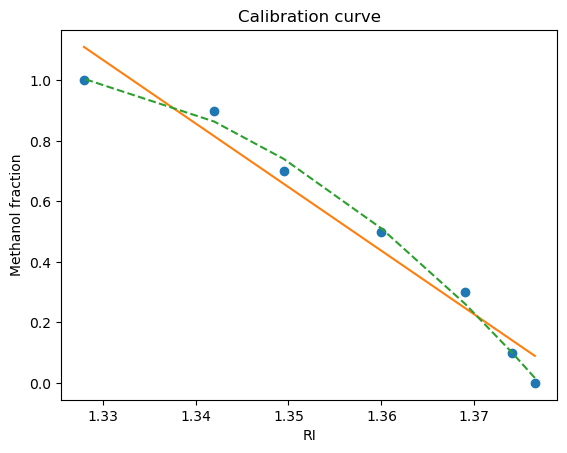

0.5105995532418319


In [126]:
# Refractive Index Calibration Curve

#Measurements
Me_fraction = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
RI = [1.3765, 1.374, 1.369, 1.360, 1.3495, 1.342, 1.328]

#fitting line at multiple degrees
Cal_a_fit, Cal_b_fit = np.polyfit(RI, Me_fraction, deg=1)
Cal_a_fit2, Cal_b_fit2, Cal_c_fit2 = np.polyfit(RI, Me_fraction, deg=2)

plt.plot(RI, Me_fraction,"o")
plt.plot(RI, np.polyval((Cal_a_fit, Cal_b_fit), RI),"-")
plt.plot(RI, np.polyval((Cal_a_fit2, Cal_b_fit2, Cal_c_fit2), RI), "--")
plt.xlabel("RI")
plt.ylabel("Methanol fraction")
plt.title('Calibration curve')
plt.show()

def Calibration(RI):
    Me_ratio = RI**2 * Cal_a_fit2 + RI*Cal_b_fit2 + Cal_c_fit2
    return Me_ratio

#use calibration function to get the methanol fraction
Me_frac = Calibration(1.36)
print(Me_frac)

In [127]:
#Constants 

R = 8.3144598    # Gas constant J/molK
g = 9.807        # Gravitational acceleration m/s^2

# Reboiler info and trey
A_r = 0.08                  # Evaporation surface area m2
dH_vap_Me = 37340        # Enthalpy of vaporisation methanol at boiling point [J/mol]
dH_vap_iso = 44000
eff = 1 #640/751         # Heater efficiency (around 0.85)
T0 = 298                 #K
V  = 0.01                # Volume of mixture in reboiler [m^3]
Iso_frac = 1-Me_frac     # Mole fraction isopropanol
dens_Me = 792     #g/dm3
dens_Iso = 786    #g/dm3
dens_mix_L = ((792+786)/2)  #g/dm3
M_Me = 32.02             #g/mol
M_Iso = 60.1             #g/mol
Vm_Me = 40.75            # molar volume methanol [cm^3/mol]
Vm = (M_Me/1000/dens_Me)*Me_frac + (M_Iso/1000/dens_Iso)*(1-Me_frac) # Molar volume of mixture [m^3/mol]
n_total = V/Vm           # Total number of moles in mixture
n_Me = Me_frac*n_total   # Number of moles of methanol
n_Iso = Iso_frac*n_total # Number of moles of isopropanol
power_percent = 0.7
power = eff*power_percent*2000      #J/s (maximum power is 2kW)
A_tray = 0.001963495408493621   #surface area of one tray in m2
lw =  0.025                      #length weir in m 
#A_weir = 
How = 0.005                      #height over outlet weir in m  
dp = 547.7                       #pressure drop over entire column in Pa
x_iso_in = 0.5                   #Isopropanol fraction inlet
x_me_in = 0.5                    #Methanol fraction inlet
RR = 0.2                         #Reflux ratio

In [128]:
(0.005*A_tray*dens_mix_L*1000)/(45)

0.17213309747794076

In [129]:
#Heat transfer coefficients 

Cp_L_me = 87.71   #J/mol.K
Cp_v_me = 47.99   #J/mol.K
Cp_L_iso = 176.16 #J/mol.K
Cp_v_iso = 110.29 #J/mol.K

#Heat transfer coefficients 

Cp_L_me = 87.71   #J/mol.K
Cp_v_me = 47.99   #J/mol.K
Cp_L_iso = 176.16 #J/mol.K
Cp_v_iso = 110.29 #J/mol.K

#Total liquid avg heat transfer coeff in J/mol.K
def Cp_L(x_me, x_iso):
    Cp_L = x_me*Cp_L_me + x_iso*Cp_L_iso
    return Cp_L

#Total vapor avg heat transfer coeff in J/mol.K
def Cp_v(y_me, y_iso):
    Cp_v = y_me*Cp_v_me + y_iso*Cp_v_iso
    return Cp_v

#Total (liquid+vapor) avg heat transfer coeff in J/mol.K
def Cp_tot(Nme_L,Niso_L,Nme_v,Niso_v):
    x_me = Nme_L/(Nme_L+Niso_L+Nme_v+Niso_v)
    x_iso = Niso_L/(Nme_L+Niso_L+Nme_v+Niso_v)
    y_me = Nme_v/(Nme_L+Niso_L+Nme_v+Niso_v)
    y_iso = Niso_v/(Nme_L+Niso_L+Nme_v+Niso_v)
    Cp_tot = x_me*Cp_L_me + x_iso*Cp_L_iso + y_me*Cp_v_me + y_iso*Cp_v_iso
    return Cp_tot


# Vapor pressure for both compounds in Pa 
def p0_me(T):
    #Antonie constants-methanol 
    A_me = 8.08097
    B_me = 1582.27
    C_me = 239.7
    #vapour pressure
    anto_me = A_me - (B_me/(T+C_me))
    p0_me_mmHg = math.pow(10,anto_me) 
    p0_me = p0_me_mmHg/0.00750062   #Pa

    return p0_me   


def p0_iso(T):
    #Antoine constants isopropanol
    A_iso = 8.00308
    B_iso =	1505.52
    C_iso = 211.6
    #vapour pressure 
    anto_iso = A_iso - (B_iso/(T+C_iso))
    p0_iso_mmHg = math.pow(10,anto_iso)
    p0_iso = p0_iso_mmHg/0.00750062   #Pa
    
    return p0_iso


In [130]:
k_me = 1.34  #m/s 
k_iso = 1.27 #m/s


In [131]:
params = {
    'R': R,          # Gas constant
    'k_me': k_me,    # mass coefficient methanol,
    'k_iso': k_iso,  # mass coefficient isopropanol
    'A_r': A_r,      #evaporation surface area of reboiler 
    'A_tray': A_tray,#evaporation surface area of each tray 
    'dens_mix_L': dens_mix_L,  #density of mixture 
    'M_Me': M_Me,
    'M_Iso': M_Iso,
    'lw': lw,
    'How': How,
    'x_me_in': x_me_in,
    'x_iso_in': x_iso_in,
    'dH_vap_Me': dH_vap_Me,
    'dH_vap_iso': dH_vap_iso,  
    'power': power 
}

In [132]:
def modelODE(t,N, params):
    
    R = params['R']
    k_me = params['k_me']
    k_iso = params['k_iso']
    A_r = params['A_r']
    A_tray = params['A_tray']
    dens_mix_L = params['dens_mix_L']
    M_Me = params['M_Me']
    M_Iso = params['M_Iso']
    lw = params['lw']
    How = params['How']
    x_me_in = params['x_me_in']
    x_iso_in = params['x_iso_in']



    T_ref = 298.15
    Q_cool = 104 
    T_cool = 293.15
    T_tray = 337.8
    A_a = ((0.05*0.01)**2) * math.pi #area of 1 hole in the top of a tray->throough which vapor goes out 

    Nme_LR = N[0]
    Niso_LR = N[1]
    Nme_vR = N[2]
    Niso_vR = N[3]
    N_L_totR = Nme_LR+Niso_LR
    N_v_totR = Nme_vR+Niso_vR

    T = N[4]

    Nme_L_tray = N[5]
    Niso_L_tray = N[6]
    Nme_v_tray = N[7]
    Niso_v_tray = N[8]
    N_L_tot_tray = Nme_L_tray+Niso_L_tray
    N_v_tot_tray = Nme_v_tray+Niso_v_tray

    N_tot = N_L_totR+N_v_totR+N_L_tot_tray+N_v_tot_tray


    #mol fractions reboiler
    y_meR = Nme_vR/N_v_totR
    x_meR = Nme_LR/N_L_totR
    y_isoR = Niso_vR/N_v_totR
    x_isoR = Niso_LR/N_L_totR

    #mol fractions tray
    y_me_tray = Nme_v_tray/N_v_tot_tray
    x_me_tray = Nme_L_tray /N_v_tot_tray
    y_iso_tray = Niso_v_tray /N_v_tot_tray
    x_iso_tray = Niso_L_tray /N_L_tot_tray

    
    dNdt = np.zeros(9)

    #p_tot = y_me*p0_me(T) + y_iso*p0_iso(T)
    p_tot = 101325
    p_tot_tray = p_tot-dp/9

    Vm_me = M_Me/1000/dens_Me
    Vm_iso = M_Iso/1000/dens_Iso
    Vm_L = (Nme_LR/N_L_totR) * Vm_me * (Niso_LR/N_L_totR) * Vm_iso
    V_R = N_L_totR * Vm_L




    if (Nme_LR>0 and Niso_LR>0 and Nme_L_tray>0 and Niso_L_tray>0 and Nme_vR>0 and Niso_vR>0 and Nme_v_tray>0 and Niso_v_tray>0):

        evap_me = 0.0000085*A_r * ((x_meR*p0_me(T) - p_tot*y_meR)/(R*T))
        evap_iso = 0.000002*A_r * ((x_isoR*p0_iso(T) - p_tot*y_isoR)/(R*T))
        evap_tray_me = 0.000002*A_tray * ((x_me_tray*p0_me(T_tray) - p_tot_tray*y_me_tray)/(R*T_tray))
        evap_tray_iso = 0.000001*A_tray * ((x_iso_tray*p0_iso(T_tray) - p_tot_tray*y_iso_tray)/(R*T_tray))

        L_inflow = 2 * (1/3600) * dens_mix_L/(x_me_in*M_Me + x_iso_in*M_Iso)
        #CONDENSER
        #steady state enthaly balance 
        #V_tray = (dens_mix_L/(x_me_tray*M_Me + x_iso_tray*M_Iso)) * 10*A_a* 0.00001  * math.sqrt((dp/8)/dens_mix_L)
        #L_condenser = V_tray
        L_condenser = Q_cool/(Cp_v(y_me_tray,y_iso_tray)*(T_tray-T_ref) + dH_vap_Me + dH_vap_iso - Cp_L(y_me_tray,y_iso_tray)*(T_cool-T_ref))
        V_tray = L_condenser
        M_holdup = (A_tray*How*dens_mix_L*1000)/(0.5*M_Me+0.5*M_Iso)
        Hol = ((Nme_L_tray+Niso_L_tray)*(x_me_tray*M_Me+x_iso_tray*M_Iso))/(dens_mix_L*A_tray*1000)
        L_weir = (((1.8385*lw*math.pow((Hol-How),3/2))*dens_mix_L)*(x_me_tray*M_Me+x_iso_tray*M_Iso))/1000
        
       
        #steady-state ethalpy balance
        
        H_F = L_inflow* Cp_L(x_me_in,x_iso_in)*(T_tray-T_ref) #Enthalpy of feed liquid entering the tray
        H_L = L_condenser*Cp_L(y_me_tray,y_iso_tray)*(T_cool-T_ref) #Enthalpy of condenser liquid entering the tray
        H_V = V_tray*(Cp_v(y_me_tray,y_iso_tray)*(T_tray-T_ref)+(y_meR*dH_vap_Me + y_isoR*dH_vap_iso)) #Enthalpy of vapor leaving the tray
        H_W = L_weir*Cp_L(x_me_tray,x_iso_tray)*(T_tray-T_ref) #Enthalpy of liquid leaving the tray
        #V_reboiler = -1*((H_L - H_W + H_F +H_V)/(Cp_v(y_meR,y_isoR)*(T-T_ref)+(y_meR*dH_vap_Me + y_isoR*dH_vap_iso)))
        V_reboiler = -1*((H_L - H_W + H_F +H_V)/(Cp_v(y_meR,y_isoR)*(T-T_ref)))
        #H_R = V_reboiler*(Cp_v(y_meR,y_isoR)*(T-T_ref)+(y_meR*dH_vap_Me + y_isoR*dH_vap_iso))#Enthalpy of vapor leaving the reboiler
        H_R = V_reboiler*(Cp_v(y_meR,y_isoR)*(T-T_ref))#Enthalpy of vapor leaving the reboiler

        #REBOILER 
        #liquid methanol 
        dNdt[0] = L_weir*x_me_tray - evap_me
        #liquid isopropanol 
        dNdt[1] = L_weir*x_iso_tray - evap_iso
        #vapor methanol
        dNdt[2] = evap_me - V_reboiler*y_meR
        #vapor isopropano
        dNdt[3] = evap_iso - V_reboiler*y_isoR
        #temperature equation 
        dNdt[4] = (power + H_W - H_R)/(Cp_tot(Nme_LR,Niso_LR,Nme_vR,Niso_vR)*(N_L_totR+N_v_totR))
    
        #TRAY
        #liquid methanol
        dNdt[5] = L_inflow*x_me_in + L_condenser*y_me_tray - evap_tray_me - L_weir*x_me_tray
        #liquid isopropanol
        dNdt[6] = L_inflow*x_iso_in + L_condenser*y_iso_tray - evap_tray_iso - L_weir*x_iso_tray
        #vapor methanol
        dNdt[7] = V_reboiler*y_meR + evap_tray_me - V_tray*y_me_tray
        #vapor isopropanol
        dNdt[8] = V_reboiler*y_isoR + evap_tray_iso - V_tray*y_iso_tray
        print(evap_me,L_weir,L_inflow, Hol,N_tot)
    elif Nme_LR <= 0 or Niso_LR <= 0 or Nme_vR <= 0 or Niso_vR <=0 or  Nme_L_tray <= 0 or Niso_L_tray <= 0 or Nme_v_tray <= 0 or Niso_v_tray <= 0:
        dNdt[0] = 0
        dNdt[1] = 0
        dNdt[2] = 0
        dNdt[3] = 0
        dNdt[4] = 0
        dNdt[5] = 0
        dNdt[6] = 0
        dNdt[7] = 0
        dNdt[8] = 0
    
    

    return dNdt

In [133]:
#M_holdup = (A_tray*How*dens_mix_L)/(0.5*M_Me+0.5*M_Iso)
#(M_holdup/(dens_mix_L*A_tray*0.8))
#print(math.pow(((M_holdup/(dens_mix_L*A_tray))),(3/2)))
#L_weir = math.pow(((((M_holdup/(dens_mix_L*A_tray))-How)/(1.41))),(3/2))*dens_mix_L*lw*60
#L_weir

In [134]:

Hol = ((2)*(0.5*M_Me+0.5*M_Iso))/(dens_mix_L*A_tray*1000)
L_weir = (((1.8385*lw*math.pow((Hol-How),3/2))*dens_mix_L)*(0.5*M_Me+0.5*M_Iso))/1000
print(L_weir)
(math.pow((Hol-How),(3/2)) * lw * 1.8 * dens_mix_L * (0.5*M_Me+0.5*M_Iso))/1000

0.021230356148691763


0.02078577158969006

In [135]:
L_inflow = 2 * (1/3600) * dens_mix_L/(x_me_in*M_Me + x_iso_in*M_Iso)
L_inflow*1000

9.5165725864814

In [136]:
N_initial = [115, 115, 1, 1, 293, 1, 1, 1, 1] # meL isoL meV isoV
#tspan = np.linspace(0, 10000, 10000)
t0, tf = 0, 10000
sol = solve_ivp(modelODE, (t0, tf), N_initial,args = (params,), method='Radau')
#N = odeint(modelODE, N_initial, tspan, args = (params,))


0.002386717433444581 0.021230356148691763 0.0095165725864814 0.059463030094298194 236.0
0.0023880574814728298 0.02114626329139447 0.0095165725864814 0.059226923760796 236.01176845335695
0.0023867174513323734 0.021230356148691763 0.0095165725864814 0.059463030094298194 236.00000171363354
0.0023867174155567886 0.021230356148691763 0.0095165725864814 0.059463030094298194 236.00000171363354
0.002386717433339219 0.021230356148691763 0.0095165725864814 0.059463030094298194 236.00000001490116
0.002386717433549943 0.021230356148691763 0.0095165725864814 0.059463030094298194 236.00000001490116
0.0023867175324611928 0.021230356148691763 0.0095165725864814 0.059463030094298194 236.0
0.002386717433444581 0.021230355871796596 0.0095165725864814 0.059463029632315395 235.99999998509884
0.002386717433444581 0.021230355617437476 0.0095165725864814 0.05946302936222426 235.99999998509884
0.002386717433444581 0.02123035629371631 0.0095165725864814 0.05946303024829246 235.99999998509884
0.00238671743344458

In [137]:
print(sol.y[7], sol.y[8])

[ 1.00000000e+00  9.97918494e-01  9.77204944e-01  8.87365526e-01
  8.68629125e-01  8.23657791e-01  7.64946811e-01  7.33758881e-01
  6.31952785e-01  5.98020471e-01  5.12205207e-01  4.40473353e-01
  4.21082403e-01  3.86045541e-01  3.39863543e-01  2.68772903e-01
  2.51895395e-01  2.09972925e-01  1.78569491e-01  1.70482719e-01
  1.55241523e-01  1.35373957e-01  1.04385043e-01  9.82991094e-02
  8.27833704e-02  7.14859169e-02  6.86538356e-02  6.20014564e-02
  5.31337148e-02  4.91781581e-02  3.74761666e-02  3.42772070e-02
  2.76988067e-02  2.27995947e-02  2.15527398e-02  1.89177527e-02
  1.54673090e-02  1.01419581e-02  5.81447376e-03  3.43044985e-03
  1.78464444e-03  1.39143927e-03  5.51171044e-04  7.58067123e-05
  6.75978473e-06  2.60090118e-06 -1.31578017e-06 -1.31578340e-06
 -1.31578371e-06 -1.31578717e-06 -1.31578717e-06 -1.31578717e-06
 -1.31578717e-06 -1.31578717e-06 -1.31578717e-06 -1.31578717e-06
 -1.31578717e-06 -1.31578717e-06 -1.31578717e-06 -1.31578717e-06
 -1.31578717e-06] [1.    

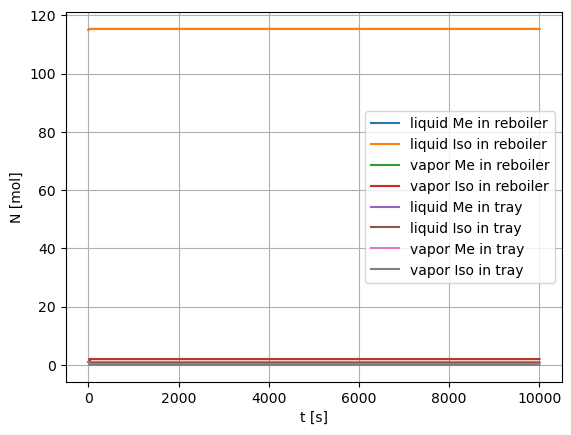

In [138]:
#plt.plot(tspan, N[:,0], label = 'liquid Me')
#plt.plot(tspan, N[:,1], label = 'liquid Iso')
#plt.plot(tspan, N[:,2], label = 'vapor Me')
#plt.plot(tspan, N[:,3], label = 'vapor Iso')

plt.plot(sol.t, sol.y[0], label = 'liquid Me in reboiler')
plt.plot(sol.t, sol.y[1], label = 'liquid Iso in reboiler')
plt.plot(sol.t, sol.y[2], label = 'vapor Me in reboiler')
plt.plot(sol.t, sol.y[3], label = 'vapor Iso in reboiler')
plt.plot(sol.t, sol.y[5], label = 'liquid Me in tray')
plt.plot(sol.t, sol.y[6], label = 'liquid Iso in tray')
plt.plot(sol.t, sol.y[7], label = 'vapor Me in tray')
plt.plot(sol.t, sol.y[8], label = 'vapor Iso in tray')

plt.legend()
plt.xlabel("t [s]")
plt.ylabel("N [mol]")
plt.grid()
plt.show()

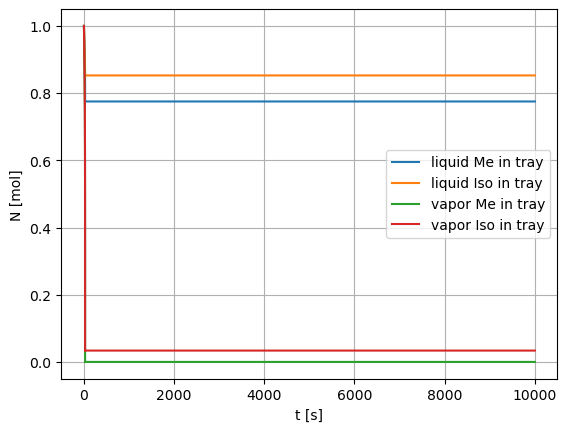

In [139]:
plt.plot(sol.t, sol.y[5], label = 'liquid Me in tray')
plt.plot(sol.t, sol.y[6], label = 'liquid Iso in tray')
plt.plot(sol.t, sol.y[7], label = 'vapor Me in tray')
plt.plot(sol.t, sol.y[8], label = 'vapor Iso in tray')

plt.legend()
plt.xlabel("t [s]")
plt.ylabel("N [mol]")
plt.grid()
plt.show()

In [140]:
30/1000

0.03

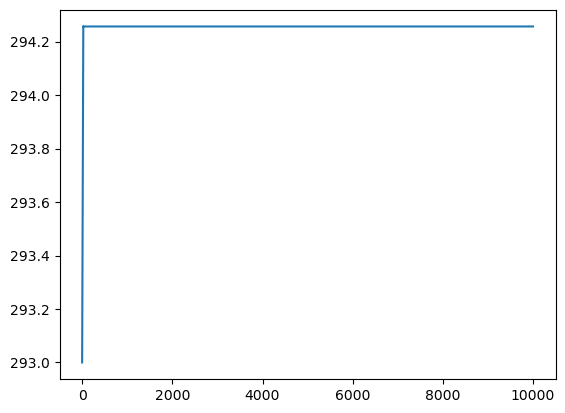

In [141]:
#plt.plot(tspan,N[:,4])
plt.plot(sol.t,sol.y[4])